In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import sent2vec

from funcs import utils, paths
from funcs.data_processing import stage1_processing

In [2]:
data_dir = utils.find_data_root()
print(data_dir)
bioconcepts_dir = data_dir / "output" / "bioconcepts"
assert bioconcepts_dir.exists()

/data/ik18445_cache/projects/vectology/stage2/data


In [4]:
terms_df_path = bioconcepts_dir / "terms_df.csv"
assert terms_df_path.exists()
ner_res_path = bioconcepts_dir / "ner_res.json"
assert ner_res_path.exists()

terms_df = pd.read_csv(terms_df_path)
print(terms_df.info())
with ner_res_path.open() as f:
    ner_res = pd.DataFrame(json.load(f))
    print(ner_res.info())
ner_res.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26548 entries, 0 to 26547
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   batch       26548 non-null  object
 1   mapping_id  26548 non-null  int64 
 2   term        26548 non-null  object
dtypes: int64(1), object(2)
memory usage: 622.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26548 entries, 0 to 26547
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   batch       26548 non-null  object
 1   mapping_id  26548 non-null  int64 
 2   term        26548 non-null  object
 3   ner_res     26548 non-null  object
dtypes: int64(1), object(3)
memory usage: 829.8+ KB
None


,batch,mapping_id,term,ner_res
0,ebi,1,gonarthrosis,[]
1,ebi,2,psoriatic and enteropathic arthropathies,"[{'ent_id': 'Disease_MESH_D007592', 'ent_term'..."
2,ebi,3,pain associated with micturition,"[{'ent_id': 'Disease_MESH_D000072716', 'ent_te..."
3,ebi,4,other mood,"[{'ent_id': 'Disease_MESH_D019964', 'ent_term'..."
4,ebi,5,preterm delivery,"[{'ent_id': 'Disease_MESH_D007752', 'ent_term'..."


In [5]:
# how many requests received api response

print("Num. terms, by batch")
print(terms_df.groupby("batch").size())

print("Num. items with identified entities, by batch")
print(ner_res[["batch", "ner_res"]]
      .assign(ner_res=lambda df: df["ner_res"]
              .apply(lambda x: [_ for _ in x if _ is not None])
              .apply(lambda x: None if len(x) == 0 else x))
      .dropna().groupby("batch").size())

Num. terms, by batch
batch
ebi     1182
efo    25366
dtype: int64
Num. items with identified entities, by batch
batch
ebi     1165
efo    23202
dtype: int64


In [6]:
biosentvec_model_path = paths.init["biosentvec_model"]
biosentvec_model = sent2vec.Sent2vecModel()
biosentvec_model.load_model(str(biosentvec_model_path))

In [7]:
# how many contain keys from embedding

from gensim.models import KeyedVectors
model_path = data_dir / ".." / "models" / "bioconceptvec" / "bioconceptvec_word2vec_skipgram.bin"
assert model_path.exists(), model_path

bioconceptvec_embeddings = KeyedVectors.load_word2vec_format(str(model_path), binary=True)

---

# prelim effects of augment on top-1 mappings

In [9]:
ebi_df = stage1_processing.get_ebi_data()
ebi_df

2022-06-23 03:25:22.794 | INFO     | funcs.data_processing.stage1_processing:get_ebi_data:32 - <class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query              1191 non-null   object
 1   MAPPED_TERM_LABEL  1191 non-null   object
 2   MAPPED_TERM_URI    1191 non-null   object
 3   MAPPING_TYPE       1191 non-null   object
 4   id                 1191 non-null   object
 5   full_id            1191 non-null   object
 6   mapping_id         1191 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 65.3+ KB

2022-06-23 03:25:22.795 | INFO     | funcs.data_processing.stage1_processing:get_ebi_data:33 - 
Exact       603
Broad       527
Narrow       47
?             7
? Broad       3
? Narrow      2
? Exact       1
Narrow?       1
Name: MAPPING_TYPE, dtype: int64


,query,MAPPED_TERM_LABEL,MAPPED_TERM_URI,MAPPING_TYPE,id,full_id,mapping_id
0,gonarthrosis,osteoarthritis || knee,EFO_0004616,Broad,EFO_0004616,http://www.ebi.ac.uk/efo/EFO_0004616,1
1,psoriatic and enteropathic arthropathies,psoriatic arthritis,EFO_0003778,? Broad,EFO_0003778,http://www.ebi.ac.uk/efo/EFO_0003778,2
2,pain associated with micturition,dysuria,EFO_0003901,? Broad,EFO_0003901,http://www.ebi.ac.uk/efo/EFO_0003901,3
3,other mood,mood disorder,EFO_0004247,? Broad,EFO_0004247,http://www.ebi.ac.uk/efo/EFO_0004247,4
4,preterm delivery,premature birth,EFO_0003917,? Exact,EFO_0003917,http://www.ebi.ac.uk/efo/EFO_0003917,5
...,...,...,...,...,...,...,...
1186,malignant neoplasm without specification of site,cancer,EFO_0000311,Broad,EFO_0000311,http://www.ebi.ac.uk/efo/EFO_0000311,1187
1187,other and unspecified types of non-hodgkin's l...,non-Hodgkins lymphoma,EFO_0005952,Exact,EFO_0005952,http://www.ebi.ac.uk/efo/EFO_0005952,1188
1188,candidiasis,"Candidiasis, Invasive",EFO_1001283,Narrow,EFO_1001283,http://www.ebi.ac.uk/efo/EFO_1001283,1189
1189,other predominantly sexually transmitted disea...,bacterial sexually transmitted disease,EFO_0003955,Narrow,EFO_0003955,http://www.ebi.ac.uk/efo/EFO_0003955,1190


In [10]:
efo_df = stage1_processing.get_efo_nodes()
efo_df

2022-06-23 03:25:28.291 | INFO     | funcs.data_processing.stage1_processing:get_efo_nodes:24 - <class 'pandas.core.frame.DataFrame'>
Int64Index: 25380 entries, 0 to 25389
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   efo_label  25380 non-null  object
 1   efo_id     25380 non-null  object
dtypes: object(2)
memory usage: 594.8+ KB



,efo_label,efo_id
0,xeroderma pigmentosum variant,http://www.orpha.net/ORDO/Orphanet_90342
1,xeroderma pigmentosum,http://www.orpha.net/ORDO/Orphanet_910
2,ischemic stroke,http://purl.obolibrary.org/obo/HP_0002140
3,cerebral ischemia,http://purl.obolibrary.org/obo/HP_0002637
4,small cell carcinoma,http://www.ebi.ac.uk/efo/EFO_0008524
...,...,...
25385,acetazolamide-responsive myotonia,http://www.orpha.net/ORDO/Orphanet_99736
25386,complete androgen insensitivity syndrome,http://www.orpha.net/ORDO/Orphanet_99429
25387,intermediate dend syndrome,http://www.orpha.net/ORDO/Orphanet_99989
25388,epiblepharon,http://www.orpha.net/ORDO/Orphanet_99169


In [11]:
file_path = data_dir / "output" / "stage2-output" / "mapping_agg_intermediates" / "BioSentVec_1.0.csv"
assert file_path.exists(), file_path
b_mappings = pd.read_csv(file_path)
b_mappings

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE
0,1,http://www.ebi.ac.uk/efo/EFO_0004616,http://www.ebi.ac.uk/efo/EFO_0004616,0.620142,1.0,Broad
1,2,http://www.ebi.ac.uk/efo/EFO_0003778,http://www.ebi.ac.uk/efo/EFO_0003778,0.697339,1.0,Other
2,8,http://www.ebi.ac.uk/efo/EFO_0000217,http://www.ebi.ac.uk/efo/EFO_0000217,0.892920,1.0,Broad
3,21,http://www.ebi.ac.uk/efo/EFO_0000685,http://www.ebi.ac.uk/efo/EFO_0000685,0.802925,1.0,Broad
4,24,http://www.ebi.ac.uk/efo/EFO_0001422,http://www.ebi.ac.uk/efo/EFO_0001422,0.853770,1.0,Broad
...,...,...,...,...,...,...
500,1175,http://www.ebi.ac.uk/efo/EFO_0002422,http://www.ebi.ac.uk/efo/EFO_0002422,0.717567,1.0,Exact
501,1176,http://www.ebi.ac.uk/efo/EFO_0008549,http://www.ebi.ac.uk/efo/EFO_0008549,0.620466,1.0,Exact
502,1180,http://purl.obolibrary.org/obo/HP_0001915,http://purl.obolibrary.org/obo/HP_0001915,0.743048,1.0,Exact
503,1185,http://www.ebi.ac.uk/efo/EFO_0009812,http://www.ebi.ac.uk/efo/EFO_0009812,0.696382,1.0,Broad


In [12]:
file_path = data_dir / "output" / "stage2-output" / "mapping_agg_intermediates" / "BioSentVec-BioConceptVec_1.0.csv"
assert file_path.exists(), file_path
bb_mappings = pd.read_csv(file_path)
bb_mappings

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE
0,8,http://www.ebi.ac.uk/efo/EFO_0000217,http://www.ebi.ac.uk/efo/EFO_0000217,0.730240,1.0,Broad
1,21,http://www.ebi.ac.uk/efo/EFO_0000685,http://www.ebi.ac.uk/efo/EFO_0000685,0.958868,1.0,Broad
2,24,http://www.ebi.ac.uk/efo/EFO_0001422,http://www.ebi.ac.uk/efo/EFO_0001422,0.940775,1.0,Broad
3,56,http://www.ebi.ac.uk/efo/EFO_1000999,http://www.ebi.ac.uk/efo/EFO_1000999,0.697513,1.0,Broad
4,57,http://www.ebi.ac.uk/efo/EFO_1001176,http://www.ebi.ac.uk/efo/EFO_1001176,0.978561,1.0,Broad
...,...,...,...,...,...,...
203,1144,http://purl.obolibrary.org/obo/HP_0000486,http://purl.obolibrary.org/obo/HP_0000486,0.772230,1.0,Exact
204,1155,http://www.ebi.ac.uk/efo/EFO_0009562,http://www.ebi.ac.uk/efo/EFO_0009562,0.661833,1.0,Exact
205,1157,http://www.ebi.ac.uk/efo/EFO_0009488,http://www.ebi.ac.uk/efo/EFO_0009488,0.935371,1.0,Exact
206,1170,http://www.ebi.ac.uk/efo/EFO_0009675,http://www.ebi.ac.uk/efo/EFO_0009675,0.638976,1.0,Exact


In [13]:
set_b = set(b_mappings["mapping_id"].tolist())
set_bb = set(bb_mappings["mapping_id"].tolist())
print(diff_b_bb := set_b.difference(set_bb))
print(diff_bb_b := set_bb.difference(set_b))

{1, 2, 26, 31, 32, 39, 41, 45, 47, 48, 54, 62, 66, 74, 81, 82, 85, 86, 89, 95, 97, 98, 102, 103, 104, 106, 109, 110, 112, 114, 118, 125, 127, 130, 134, 135, 137, 152, 155, 158, 175, 178, 179, 182, 183, 199, 201, 204, 215, 216, 219, 230, 233, 242, 245, 249, 252, 262, 270, 276, 278, 279, 283, 286, 287, 288, 289, 292, 294, 297, 300, 301, 305, 309, 311, 313, 315, 321, 323, 324, 325, 326, 332, 339, 341, 342, 344, 348, 350, 352, 353, 354, 355, 360, 364, 366, 373, 374, 376, 377, 380, 382, 388, 390, 396, 400, 401, 402, 403, 405, 406, 407, 408, 412, 417, 419, 421, 424, 425, 426, 427, 428, 431, 432, 437, 439, 440, 442, 443, 444, 445, 452, 488, 491, 492, 493, 494, 495, 496, 498, 503, 506, 511, 513, 517, 520, 521, 527, 531, 533, 536, 537, 538, 541, 543, 544, 548, 550, 553, 557, 558, 559, 571, 578, 581, 584, 585, 586, 593, 595, 597, 598, 605, 609, 610, 611, 613, 614, 615, 616, 617, 618, 623, 624, 625, 634, 637, 638, 639, 640, 644, 645, 647, 651, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664

In [14]:
df_b_bb = b_mappings[b_mappings["mapping_id"].isin(diff_b_bb)].merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)

df_bb_b = bb_mappings[bb_mappings["mapping_id"].isin(diff_bb_b)].merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)

In [15]:
df_b_bb.head()

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE,ebi_label,manual_label,prediction_label
0,1,http://www.ebi.ac.uk/efo/EFO_0004616,http://www.ebi.ac.uk/efo/EFO_0004616,0.620142,1.0,Broad,gonarthrosis,"osteoarthritis, knee","osteoarthritis, knee"
1,2,http://www.ebi.ac.uk/efo/EFO_0003778,http://www.ebi.ac.uk/efo/EFO_0003778,0.697339,1.0,Other,psoriatic and enteropathic arthropathies,psoriatic arthritis,psoriatic arthritis
2,26,http://www.ebi.ac.uk/efo/EFO_0002950,http://www.ebi.ac.uk/efo/EFO_0002950,0.553243,1.0,Broad,supervision of normal pregnancy,pregnancy,pregnancy
3,31,http://www.ebi.ac.uk/efo/EFO_0003777,http://www.ebi.ac.uk/efo/EFO_0003777,0.586568,1.0,Broad,complications and ill defined descriptions of ...,heart disease,heart disease
4,32,http://www.ebi.ac.uk/efo/EFO_0003882,http://www.ebi.ac.uk/efo/EFO_0003882,0.545301,1.0,Broad,osteoporosis in diseases classified elsewhere,osteoporosis,osteoporosis


In [16]:
df_bb_b.head()

,mapping_id,manual,prediction,score,nx,MAPPING_TYPE,ebi_label,manual_label,prediction_label
0,56,http://www.ebi.ac.uk/efo/EFO_1000999,http://www.ebi.ac.uk/efo/EFO_1000999,0.697513,1.0,Broad,other specific arthropathies,joint disease,joint disease
1,1078,http://www.ebi.ac.uk/efo/EFO_1000999,http://www.ebi.ac.uk/efo/EFO_1000999,0.724516,1.0,Broad,other specific joint derangements,joint disease,joint disease
2,75,http://purl.obolibrary.org/obo/HP_0003110,http://purl.obolibrary.org/obo/HP_0003110,0.897228,1.0,Broad,other abnormal findings in urine,abnormality of urine homeostasis,abnormality of urine homeostasis
3,76,http://purl.obolibrary.org/obo/HP_0004299,http://purl.obolibrary.org/obo/HP_0004299,0.827097,1.0,Broad,unspecified abdominal hernia,hernia of the abdominal wall,hernia of the abdominal wall
4,573,http://purl.obolibrary.org/obo/HP_0004299,http://purl.obolibrary.org/obo/HP_0004299,0.858415,1.0,Exact,abdominal hernia,hernia of the abdominal wall,hernia of the abdominal wall


In [17]:
file_path = data_dir / "output" / "stage2-output" / "biosentvec-top-100.csv"
assert file_path.exists(), file_path

top100_b = pd.read_csv(file_path)

file_path = data_dir / "output" / "stage2-output" / "biosentvec-bioconceptvec-skipgram-top-100.csv"
assert file_path.exists(), file_path

top100_bb = pd.read_csv(file_path)

print(top100_b.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119100 entries, 0 to 119099
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mapping_id  119100 non-null  int64  
 1   manual      119100 non-null  object 
 2   prediction  119100 non-null  object 
 3   score       118900 non-null  float64
 4   nx          119100 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ MB
None


In [19]:
# tmp

MAPPING_ID = 782
# MAPPING_ID = 144
print("ebi_label: ", df_bb_b[df_bb_b["mapping_id"] == MAPPING_ID]["ebi_label"].tolist()[0])
truth = df_bb_b[df_bb_b["mapping_id"] == MAPPING_ID]["manual"].tolist()[0]
print("ground truth label: ", df_bb_b[df_bb_b["manual"] == truth]["manual_label"].tolist()[0])
top100_b_1 = top100_b[top100_b["mapping_id"] == MAPPING_ID].reset_index(drop=True).merge(
    ebi_df[["mapping_id", "query"]].rename(columns={"query": "ebi_label"}),
    on=["mapping_id"]
).merge(
    efo_df.rename(columns={"efo_label": "manual_label", "efo_id": "manual"}),
    on=["manual"]
).merge(
    efo_df.rename(columns={"efo_label": "prediction_label", "efo_id": "prediction"}),
    on=["prediction"]
)
print(top100_b_1.head())

ebi_label:  neurological injury/trauma
ground truth label:  nervous system injury
   mapping_id                                manual  \
0         782  http://www.ebi.ac.uk/efo/EFO_0009490   
1         782  http://www.ebi.ac.uk/efo/EFO_0009490   
2         782  http://www.ebi.ac.uk/efo/EFO_0009490   
3         782  http://www.ebi.ac.uk/efo/EFO_0009490   
4         782  http://www.ebi.ac.uk/efo/EFO_0009490   

                                     prediction     score        nx  \
0          http://www.ebi.ac.uk/efo/EFO_0000546  0.743893  0.625000   
1          http://www.ebi.ac.uk/efo/EFO_0009505  0.680324  0.555556   
2          http://www.ebi.ac.uk/efo/EFO_0009502  0.662430  0.555556   
3          http://www.ebi.ac.uk/efo/EFO_0009476  0.645532  0.555556   
4  http://purl.obolibrary.org/obo/MONDO_0037747  0.639792  0.500000   

                    ebi_label           manual_label  prediction_label  
0  neurological injury/trauma  nervous system injury            injury  
1  neurologica

---

# prelim effects of augment on top-n mappings

In [20]:
wa_top1_path = data_dir / "output" / "stage2-output" / "weighted_average_top1_df.csv"
wa_top10_path = data_dir / "output" / "stage2-output" / "weighted_average_top10_df.csv"
assert wa_top1_path.exists(), wa_top1_path
assert wa_top10_path.exists(), wa_top10_path

wa_top1 = pd.read_csv(wa_top1_path)
print(wa_top1.shape)
wa_top1 = wa_top1[wa_top1["Model"].isin(["BioSentVec", "BioSentVec-BioConceptVec"]) ].reset_index(drop=True)
print(wa_top1.shape)

wa_top10 = pd.read_csv(wa_top10_path)
print(wa_top10.shape)
wa_top10 = wa_top10[wa_top10["Model"].isin(["BioSentVec", "BioSentVec-BioConceptVec"]) ].reset_index(drop=True)
print(wa_top10.shape)

(11770, 3)
(2354, 3)
(10593, 3)
(2354, 3)


In [21]:
wa_top1.groupby("Model").describe()

value                                           \
                           count      mean       std    min    25%    50%   
Model                                                                       
BioSentVec                1177.0  0.647025  0.381440  0.020  0.214  0.833   
BioSentVec-BioConceptVec  1177.0  0.456788  0.360289  0.024  0.129  0.333   

                                     
                           75%  max  
Model                                
BioSentVec                1.00  1.0  
BioSentVec-BioConceptVec  0.85  1.0

In [22]:
wa_top10.groupby("Model").describe()

value                                           \
                           count      mean       std    min    25%    50%   
Model                                                                       
BioSentVec                1177.0  0.453681  0.186196  0.058  0.314  0.454   
BioSentVec-BioConceptVec  1177.0  0.304012  0.159323  0.036  0.178  0.278   

                                        
                            75%    max  
Model                                   
BioSentVec                0.594  0.923  
BioSentVec-BioConceptVec  0.417  0.926

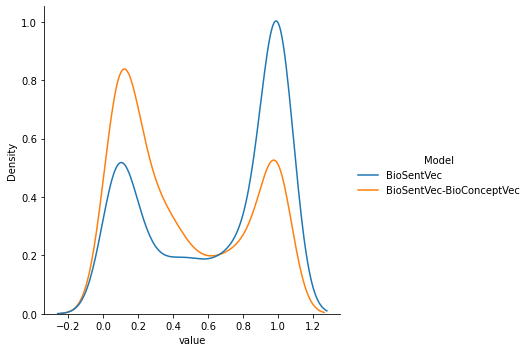

In [23]:
sns.displot(
    x="value",
    hue="Model",
    kind="kde",
    data=wa_top1
)

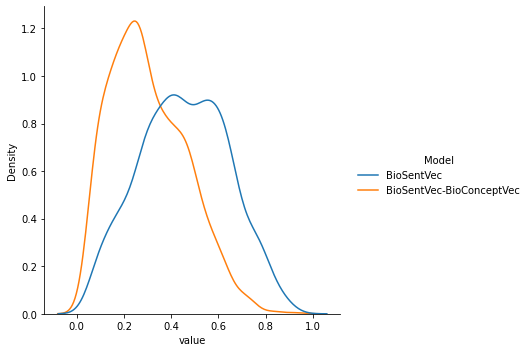

In [24]:
sns.displot(
    x="value",
    hue="Model",
    kind="kde",
    data=wa_top10
)